In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [ ]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

Exploratory Data Analysis (EDA):

In [ ]:
df= pd.read_csv('/content/diabetes (1).csv')

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
df.duplicated().sum()

np.int64(0)

<Axes: >

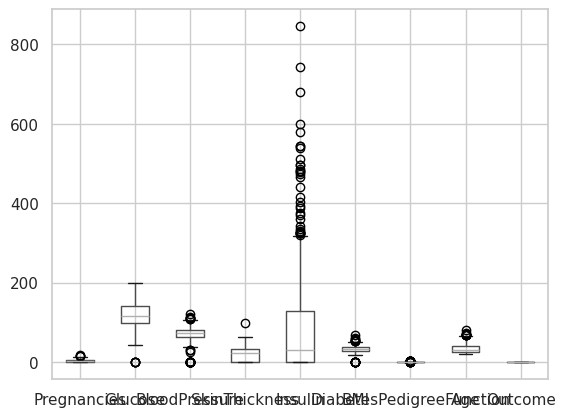

In [ ]:
# Outlier detection
df.boxplot()

In [ ]:
# Outlier capping
def outlier_capping(df,column):
  Q1=df[column].quantile(0.25)
  Q3=df[column].quantile(0.75)
  IQR= Q3-Q1
  lower_extreme= Q1-1.5*IQR
  upper_extreme= Q3+1.5*IQR
  df[column]= df[column].apply(lambda x: lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(['int','float']).columns:
  outlier_capping(df,col)

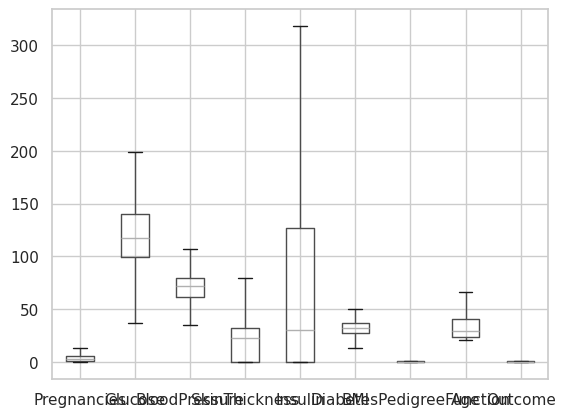

In [ ]:
df.boxplot()
plt.show()

In [ ]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove('Outcome')

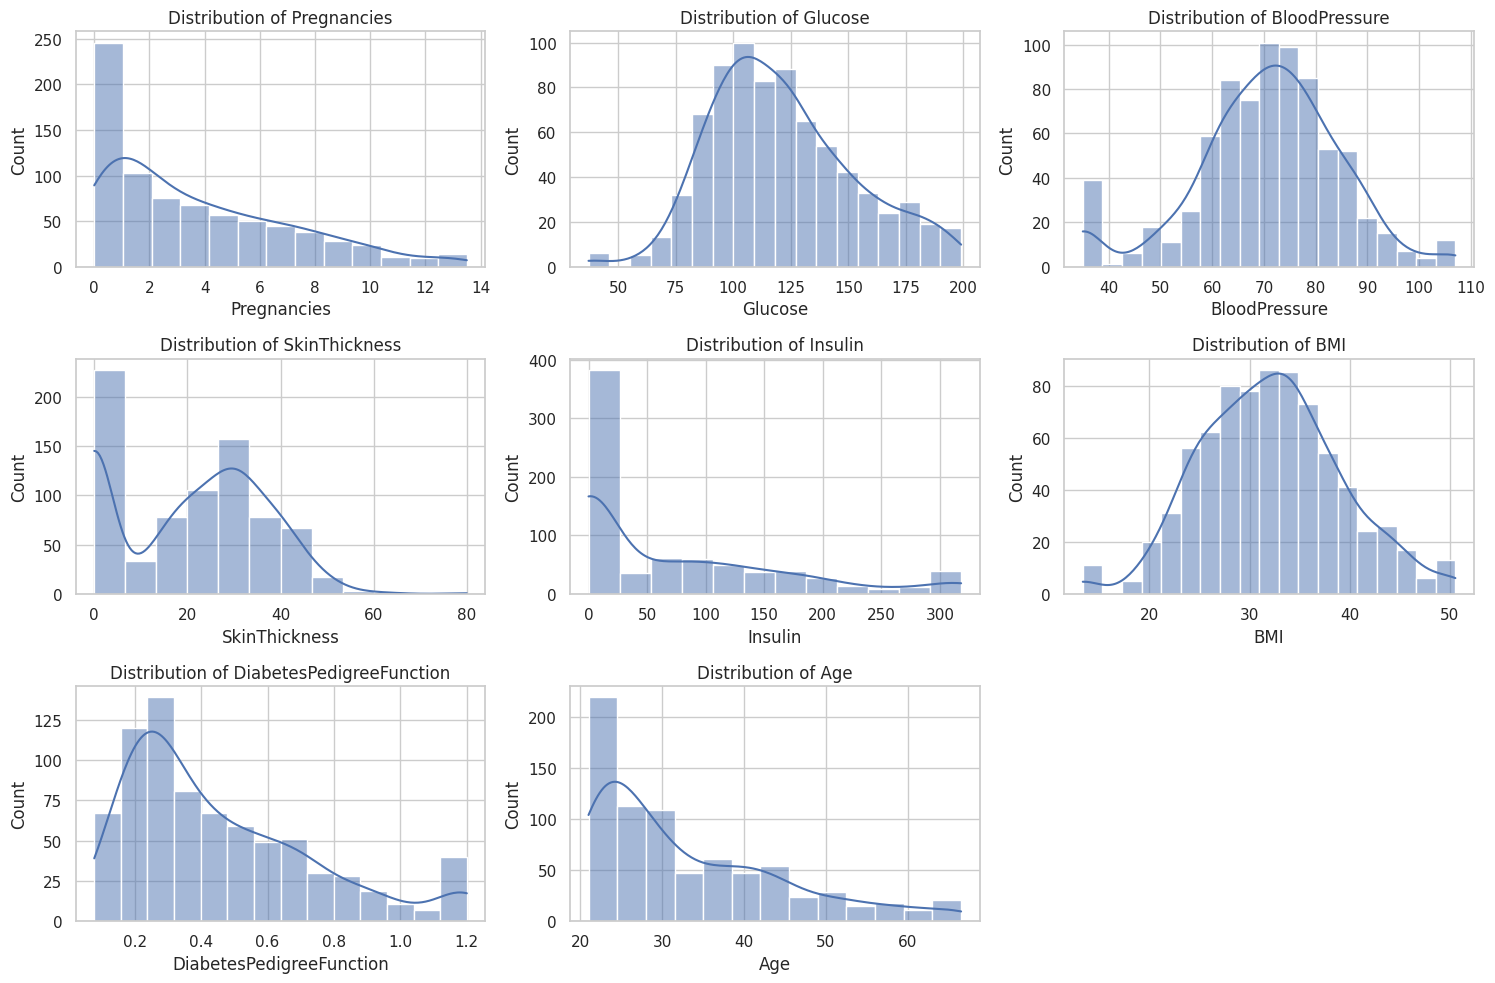

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

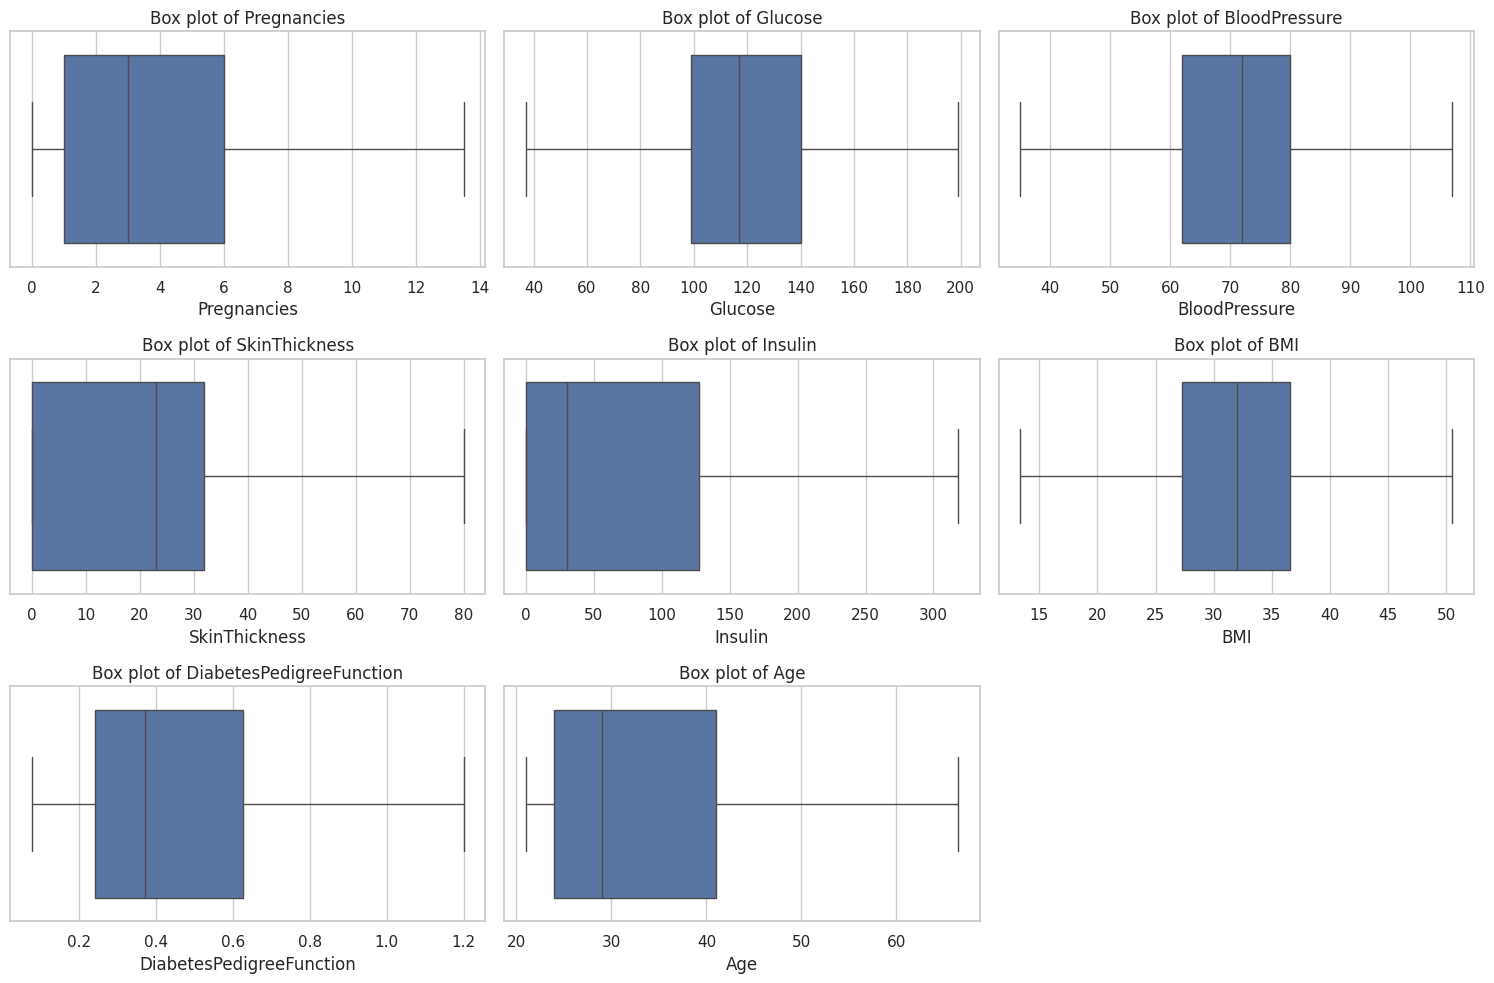

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()

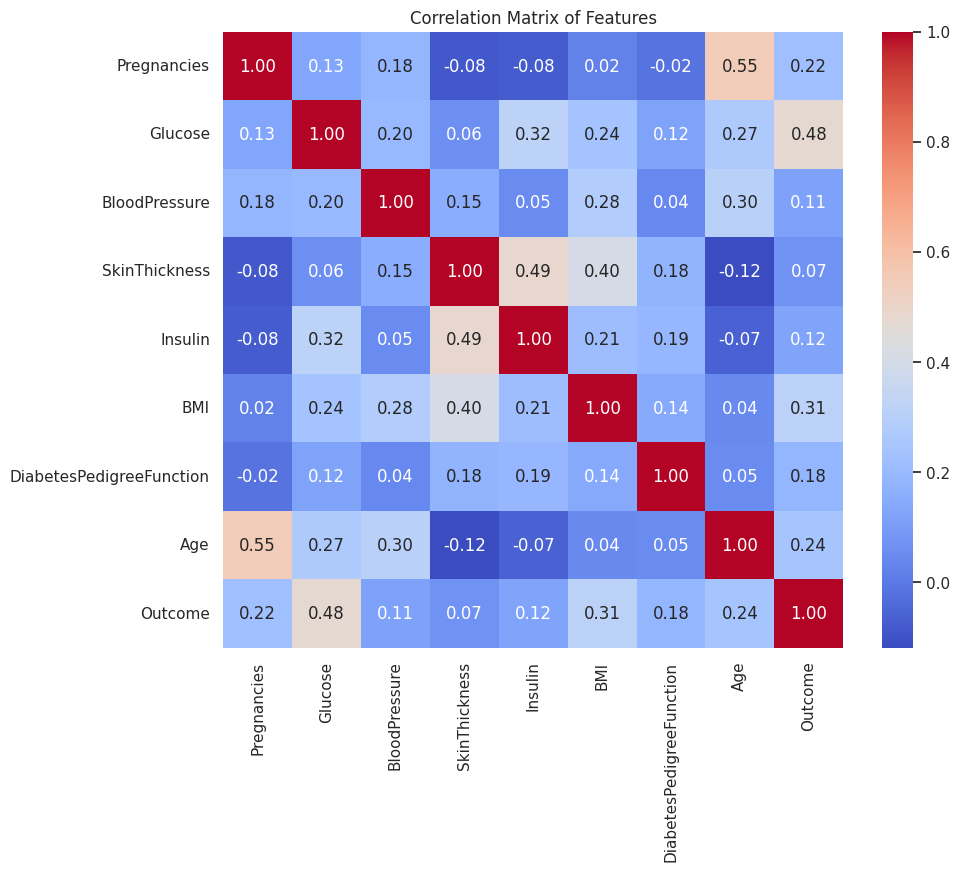

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

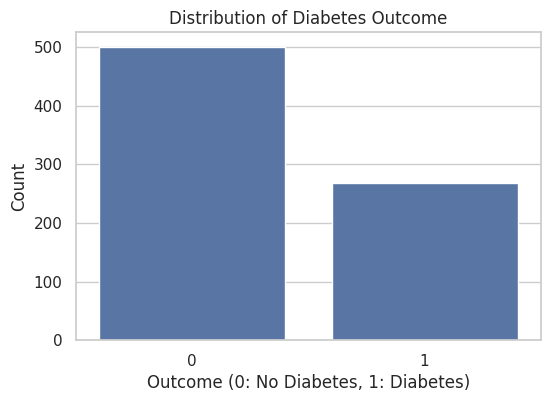

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome (0: No Diabetes, 1: Diabetes)')
plt.ylabel('Count')
plt.show()

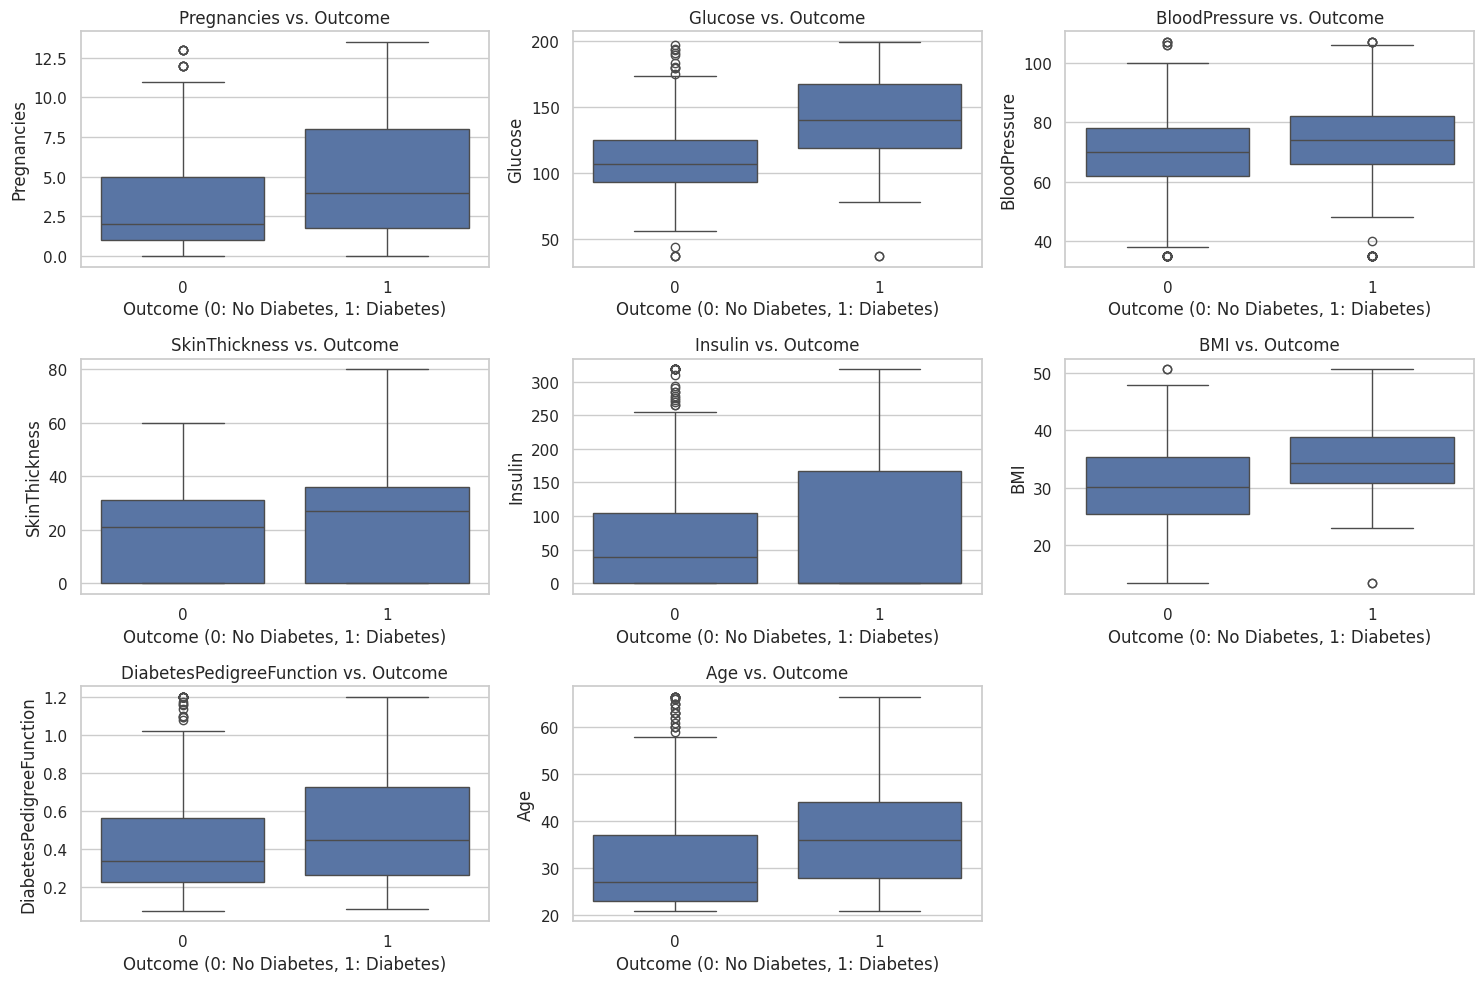

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Outcome', y=feature, data=df)
    plt.title(f'{feature} vs. Outcome')
    plt.xlabel('Outcome (0: No Diabetes, 1: Diabetes)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

Data Preprocessing:

In [ ]:
# Identify columns with biologically implausible zeros
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [ ]:
# Replace 0 values with NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

In [ ]:
# Impute missing values with the median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[cols_with_zeros] = imputer.fit_transform(df[cols_with_zeros])

In [ ]:
# Scale the numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Exclude the target variable 'Outcome' from scaling
numerical_features.remove('Outcome')

In [ ]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.647150,0.861926,0.092691,0.686889,-0.156977,0.209359,0.588927,1.445691,1
1,-0.848970,-1.159433,-0.330201,-0.009674,-0.156977,-0.784254,-0.378101,-0.189304,0
2,1.245598,1.984903,-0.471166,-0.009674,-0.156977,-1.252672,0.746595,-0.103252,1
3,-0.848970,-1.031093,-0.330201,-0.706238,-0.667869,-0.571337,-1.022787,-1.049828,0
4,-1.148194,0.508990,-2.162737,0.686889,0.551680,1.557835,2.596563,-0.017199,1


In [ ]:
features = df.drop('Outcome', axis=1)
target = df['Outcome']

Building Predictive Models:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 8)
(154, 8)
(614,)
(154,)


In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
# Instantiate the models with default parameters
lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

In [ ]:
# Train the models
lgbm_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)

print("LightGBM model trained.")
print("XGBoost model trained.")

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# Make predictions
lgbm_pred = lgbm_model.predict(x_test)
xgb_pred = xgb_model.predict(x_test)

In [ ]:
# Make probability predictions for the positive class
lgbm_pred_proba = lgbm_model.predict_proba(x_test)[:, 1]
xgb_pred_proba = xgb_model.predict_proba(x_test)[:, 1]

In [ ]:
# Evaluate LightGBM model
lgbm_accuracy = accuracy_score(y_test, lgbm_pred)
lgbm_precision = precision_score(y_test, lgbm_pred)
lgbm_recall = recall_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
lgbm_roc_auc = roc_auc_score(y_test, lgbm_pred_proba)

In [ ]:
print("LightGBM Model Performance:")
print(f"Accuracy: {lgbm_accuracy:.4f}")
print(f"Precision: {lgbm_precision:.4f}")
print(f"Recall: {lgbm_recall:.4f}")
print(f"F1-score: {lgbm_f1:.4f}")
print(f"ROC AUC Score: {lgbm_roc_auc:.4f}")
print("-" * 30)

LightGBM Model Performance:
Accuracy: 0.7143
Precision: 0.5902
Recall: 0.6545
F1-score: 0.6207
ROC AUC Score: 0.7723
------------------------------


In [ ]:
# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

In [ ]:
print("XGBoost Model Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-score: {xgb_f1:.4f}")
print(f"ROC AUC Score: {xgb_roc_auc:.4f}")
print("-" * 30)

XGBoost Model Performance:
Accuracy: 0.7143
Precision: 0.5932
Recall: 0.6364
F1-score: 0.6140
ROC AUC Score: 0.7642
------------------------------


In [ ]:
# Create a DataFrame to compare the metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'LightGBM': [lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1, lgbm_roc_auc],
    'XGBoost': [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc]
}
metrics_df = pd.DataFrame(metrics_data)

In [ ]:
print("Performance Comparison:")
display(metrics_df)

Performance Comparison:


,Metric,LightGBM,XGBoost
0,Accuracy,0.714286,0.714286
1,Precision,0.590164,0.593220
2,Recall,0.654545,0.636364
3,F1-score,0.620690,0.614035
4,ROC AUC,0.772268,0.764187
